In [1]:
DATA_FOLDER = './data/'
MOVIES_FOLDER = DATA_FOLDER + 'movies_summaries/'
PLOT_SUMMARY_FOLDER = DATA_FOLDER + 'corenlp_plot_summaries'

REPORT_FOLDER = './gen/reports/'
ETHNICITY_FILE = './gen/ethnicities.tsv'

CHARACTERS_FILE = MOVIES_FOLDER + 'character.metadata.tsv'
MOVIES_FILE = MOVIES_FOLDER + 'movie.metadata.tsv'
PLOT_SUMMARIES_FILE = MOVIES_FOLDER + 'plot_summaries.txt'
TROPES_FILE = MOVIES_FOLDER + 'tvtropes.clusters.txt'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import datetime

from pandas_profiling import ProfileReport
%matplotlib inline

from data_wrangling_tools import *

# Neural Networks
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, RobustScaler, Normalizer
from sklearn.model_selection import train_test_split


from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

In [3]:
# load movies
movies = load_movies(MOVIES_FILE)
# clean features    
movies = clean_unknowns(movies)
movies = clean_jsons(movies)

In [4]:
movies.shape

(81741, 9)

In [5]:
def drop_nulls(df):
    return df.dropna(subset=['release_date', 'box_office_revenue', 'runtime'])

In [6]:
print(f'Movies: {movies.shape[0]}')
movies_dropna = drop_nulls(movies)
print(f'Movies With dropped nulls: {movies_dropna.shape[0]}')

Movies: 81741
Movies With dropped nulls: 8242


In [7]:
def to_1D(series):
 return pd.Series([x for _list in series for x in _list])

In [8]:
countries = to_1D(movies_dropna['countries']).unique()
genres = to_1D(movies_dropna['genres']).unique()
languages = to_1D(movies_dropna['languages']).unique()
print(f'Countries: {len(countries)}')
print(f'Genres: {len(genres)}')
print(f'Languages: {len(languages)}')

Countries: 90
Genres: 312
Languages: 144


In [72]:
def augment_movies(movies, countries, genres, languages, onehot=True):
    movies_augmented = movies.copy()

    if onehot:
        for country in countries:
            movies_augmented[f'country:{country}'] = movies_augmented['countries'].apply(lambda x: 1 if country in x else 0)

        for genre in genres:
            movies_augmented[f'genre:{genre}'] = movies_augmented['genres'].apply(lambda x: 1 if genre in x else 0)

        # for language in languages:
        #     movies_augmented[f'language:{language}'] = movies_augmented['languages'].apply(lambda x: 1 if language in x else 0)

    movies_augmented['release_date'] = movies_augmented['release_date'].apply(lambda x: x.toordinal() if not pd.isna(x) else 0)
    movies_augmented['runtime'] = movies_augmented['runtime'].apply(lambda x: x if not pd.isna(x) else 0)

    movies_augmented = movies_augmented.drop(['wiki_movie_id', 'freebase_movie_id', 'name', 'countries', 'genres', 'languages'], axis=1)

    return movies_augmented

dataset1 = augment_movies(movies_dropna, countries, genres, languages, onehot=True)
dataset1.describe()

,release_date,box_office_revenue,runtime,country:United States of America,country:United Kingdom,country:South Africa,country:Mexico,country:South Korea,country:France,country:Yugoslavia,...,genre:Samurai cinema,genre:Alien invasion,genre:British New Wave,genre:Gay pornography,genre:Supermarionation,genre:Illnesses & Disabilities,genre:Period Horror,genre:The Netherlands in World War II,genre:Revisionist Fairy Tale,genre:Goat gland
count,8242.000000,8.242000e+03,8242.000000,8242.000000,8242.000000,8242.000000,8242.000000,8242.000000,8242.000000,8242.000000,...,8242.000000,8242.000000,8242.000000,8242.000000,8242.000000,8242.000000,8242.000000,8242.000000,8242.000000,8242.000000
mean,727000.938364,4.843382e+07,105.643375,0.835719,0.114171,0.002669,0.005096,0.033244,0.060180,0.000728,...,0.000364,0.000364,0.000243,0.000121,0.000121,0.000121,0.000121,0.000121,0.000243,0.000121
std,7159.870877,1.127363e+08,23.522277,0.370552,0.318039,0.051599,0.071207,0.179285,0.237834,0.026973,...,0.019076,0.019076,0.015577,0.011015,0.011015,0.011015,0.011015,0.011015,0.015577,0.011015
min,698754.000000,1.000000e+04,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,724631.000000,2.136452e+06,93.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,729247.000000,1.088657e+07,102.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,732429.000000,4.150290e+07,114.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,734794.000000,2.782275e+09,1003.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


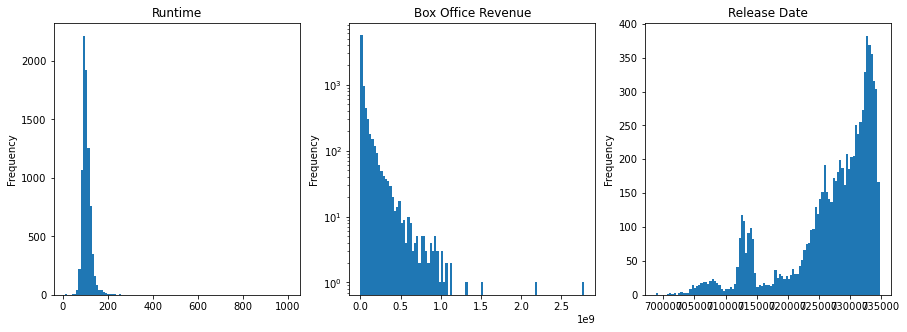

In [73]:
def plot_dataset(dataset):
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    dataset["runtime"].plot.hist(bins=100, ax=axs[0])
    dataset["box_office_revenue"].plot.hist(bins=100, log=True, ax=axs[1])
    dataset["release_date"].plot.hist(bins=100, ax=axs[2])

    axs[0].set_title("Runtime")
    axs[1].set_title("Box Office Revenue")
    axs[2].set_title("Release Date")
    plt.show()

plot_dataset(dataset1)

In [74]:
def remove_outliers(dataset, column, q_low, q_high):
    new_dataset = dataset[(dataset[column] > dataset[column].quantile(q_low)) & (dataset[column] < dataset[column].quantile(q_high))]
    print(f'Dropped {dataset.shape[0] - new_dataset.shape[0]} outliers from {column}')
    return new_dataset

Dropped 176 outliers from runtime
Dropped 82 outliers from box_office_revenue
Dropped 81 outliers from release_date


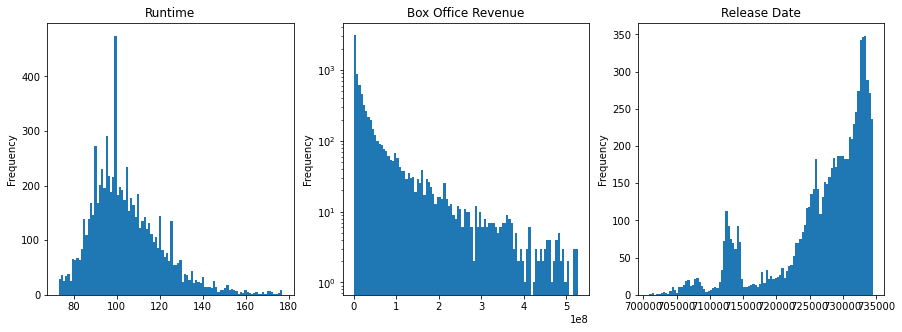

In [75]:
dataset2 = dataset1.copy()

dataset2 = remove_outliers(dataset2, 'runtime', 0.01, 0.99)
dataset2 = remove_outliers(dataset2, 'box_office_revenue', 0, 0.99)
dataset2 = remove_outliers(dataset2, 'release_date', 0, 0.99)
plot_dataset(dataset2)

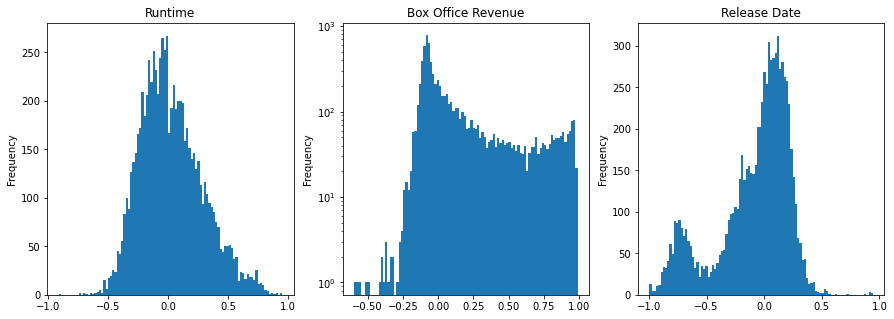

In [76]:
dataset3 = dataset2.copy()

scaler = RobustScaler().fit(dataset3)
dataset3 = pd.DataFrame(scaler.transform(dataset3), columns=dataset3.columns)

normalizer = Normalizer().fit(dataset3)
dataset3 = pd.DataFrame(normalizer.transform(dataset3), columns=dataset3.columns)

plot_dataset(dataset3)

In [77]:
dataset = dataset3.copy()

x, y = dataset.drop(['box_office_revenue'], axis=1), dataset['box_office_revenue']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [78]:
x_train.describe()

,release_date,runtime,country:United States of America,country:United Kingdom,country:South Africa,country:Mexico,country:South Korea,country:France,country:Yugoslavia,country:Germany,...,genre:Samurai cinema,genre:Alien invasion,genre:British New Wave,genre:Gay pornography,genre:Supermarionation,genre:Illnesses & Disabilities,genre:Period Horror,genre:The Netherlands in World War II,genre:Revisionist Fairy Tale,genre:Goat gland
count,6322.000000,6322.000000,6322.000000,6322.000000,6322.000000,6322.000000,6322.000000,6322.000000,6322.000000,6322.000000,...,6322.000000,6322.000000,6322.000000,6322.000000,6322.000000,6322.0,6322.0,6322.000000,6322.000000,6322.0
mean,-0.092861,0.030882,-0.061108,0.038129,0.000984,0.001620,0.014407,0.019964,0.000203,0.015968,...,0.000087,0.000141,0.000046,0.000038,0.000040,0.0,0.0,0.000033,0.000035,0.0
std,0.314427,0.257365,0.141508,0.110302,0.018704,0.025047,0.077875,0.080362,0.008523,0.070218,...,0.004880,0.006482,0.003621,0.003006,0.003206,0.0,0.0,0.002649,0.002780,0.0
min,-0.996457,-0.909213,-0.682386,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0
25%,-0.231221,-0.154320,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0
50%,-0.003481,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0
75%,0.133946,0.190292,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0
max,0.935309,0.950984,0.000000,0.839478,0.486927,0.642330,0.665954,0.631864,0.460450,0.572765,...,0.283641,0.316358,0.287902,0.238986,0.254920,0.0,0.0,0.210648,0.221052,0.0


In [79]:
y_train.describe()

count    6322.000000
mean        0.152317
std         0.324513
min        -0.597228
25%        -0.079242
50%         0.001504
75%         0.293079
max         0.990626
Name: box_office_revenue, dtype: float64

In [80]:
import tensorflow as tf

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.optimizers import Adam
from keras.layers import Normalization
from keras import Input
from tensorflow.keras.optimizers.schedules import ExponentialDecay

from tqdm.notebook import tqdm
from tqdm.keras import TqdmCallback

In [81]:
def plot_loss(history, ax, log=False):
    ax.plot(history['loss'])
    ax.plot(history['val_loss'])
    if log:
        ax.set_yscale('log')

    ax.set_title('Model loss')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.legend(['train', 'test'], loc='upper right')

def plot_preds_heatmap(y_pred, y_test, ax, displot):
    if displot:
        sns.displot(x=y_pred, y=y_test, kind="kde", fill=True, thresh=0.05, levels=10, ax=ax)
    ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
    ax.scatter(x=y_pred, y=y_test, alpha=0.3, s=5, c='red')

    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_title('Predicted vs Actual')

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

50/50 [==============================] - 0s 2ms/step


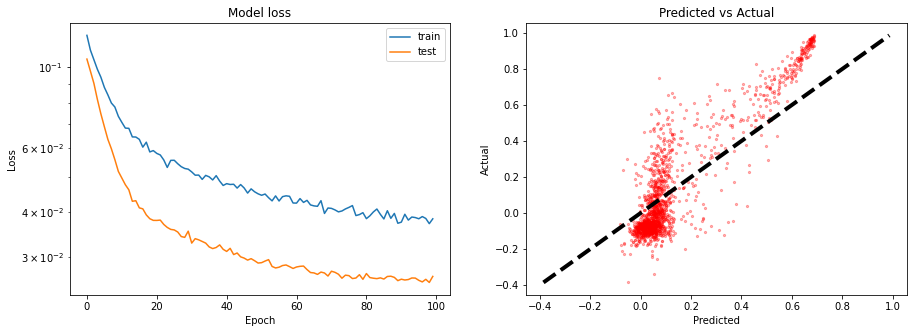

In [84]:
def baseline_model(input_dim, lr):
    """
    """
    model = Sequential()

    model.add(Dense(64, input_dim=input_dim, activation='relu'))

    model.add(Dense(32, activation='relu'))
    
    model.add(Dense(16, activation='relu'))
    
    model.add(Dense(8, activation='relu'))
    
    model.add(Dense(4, activation='relu'))
    
    model.add(Dense(1))

    model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=lr))

    return model

def plot_model(x_test, y_test, lr, epochs=10, batch_size=10, displot=False, log=False):
    """
    """
    model = baseline_model(x_train.shape[1], lr=lr)
    history = model.fit(x=x_train,
                        y=y_train,
                        validation_data=(x_test, y_test),
                        epochs=epochs,
                        batch_size=batch_size,
                        verbose=0,
                        callbacks=[TqdmCallback(verbose=1)]
                    )

    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    
    plot_loss(history.history, ax[0], log=log)
    
    y_pred = model.predict(x_test)

    pred = y_pred[:, 0]
    test = y_test.to_numpy()

    plot_preds_heatmap(pred, test, ax[1], displot)

lr_schedule = 1e-4

plot_model(x_test, y_test, lr=lr_schedule, epochs=100, batch_size=30, displot=False, log=True)